In [1]:
cd ..

/root/workspace/DBSCAN


In [2]:
%load_ext autoreload
%autoreload 2

import time 
from src.dbscan import *
from src.utils import *
from src.metrics import *
from src.clusterization_performance import *
from src.datasets import Dataset
from src.dbscanrn_optimized import *
from src.dbscanrn import *
from src.normalization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)
# plt.style.use('dark_background')

# Datasets

### Dataset from lecture

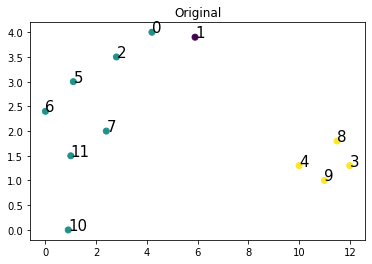

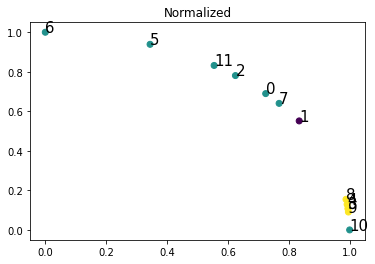

In [3]:
dataset = Dataset('./data/lecture_dataset.txt')
X, y = dataset.X, dataset.y
display_points(X, y, 'Original', numerate=True)

normalization = Norm()
X = normalization.run(X)
display_points(X, y, 'Normalized', numerate=True)

# DBSCANRN (cosine dissimilarity)

/usr/local/lib/python3.10/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.10/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


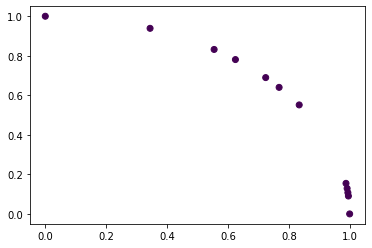

In [5]:
timer_start = time.time()
params = {
    'k': 4,
    'similarity': cosine_dissimilarity
}

algorithm = DBSCANRN_opt(**params)

name = get_name(
    algorithm_name=algorithm.name, 
    dataset_name=dataset.name, 
    n_dimentions=dataset.n_dimentions, 
    n_rows=dataset.n_rows,
    **params
)

algorithm.log_output = f'./out/LOG_{name}.log'
algorithm.fit_transform(X)
total_runtime = (time.time() - timer_start) * 1000

display_points(algorithm.X, algorithm.y_pred)
# score = evaluate(algorithm.y_pred, y, algorithm.X)

In [6]:
algorithm.get_logs()

,time [ms],operation,point_id,value,string
0,0.000000,start log,NaN,NaN,NaN
1,14.539480,dist_to_ref_point_time,NaN,0.001192,NaN
2,15.878916,sorting_dist_time,0.0,0.409842,NaN
3,21.296740,tiknn_neighbors_id,0.0,NaN,11;2;7;1
4,21.889687,|tiknn_neighbors|,0.0,4.000000,NaN
...,...,...,...,...,...
71,148.030281,|tirnn_neighbors|,10.0,2.000000,NaN
72,148.745298,tirnn_neighbors_id,11.0,NaN,6;5;2;0
73,149.720192,|tirnn_neighbors|,11.0,4.000000,NaN
74,150.310278,tirnn_time,NaN,139.412642,NaN


# OUT

In [7]:
timer_start = time.time()
logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': algorithm.X[:, 0],
    'y': algorithm.X[:, 1],
    'point_type': algorithm.state, # 1 - core, 0 - border, -1 - noise
    'CId': algorithm.y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations


# STAT

In [7]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'].__name__,
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file': dataset.runtime,
    'normalization of vectors': normalization.runtime,
    "Eps-neighborhood timer": logs['time [ms]'][logs['operation'] == 'Eps_time'].sum(),
    'Clustering timer': logs['time [ms]'].max(),
    'saving results to OUT time': saving_OUT_time,
    "dist_to_ref_point_time": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum(),
    'total runtime': total_runtime,
    "sorting_dist_time": logs[logs['operation'] == 'sorting_dist_time']['value'].sum(),
    "tiknn_time": logs[logs['operation'] == 'tiknn_time']['value'].sum(),
    "tirnn_time": logs[logs['operation'] == 'tirnn_time']['value'].sum(),
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(algorithm.y_pred),
    'RAND': score['adjusted_rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.01699209213256836


,values
name of the input fil,lecture_dataset
# of dimensions of a point,2
# of points in the input file,12
epsilon,
minPts,
k,4
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file,14.960289
normalization of vectors,0.900269


# DEBUG

In [8]:
mask1 = logs['operation'] == '|tiknn_neighbors|'
mask2 = logs['operation'] == 'tiknn_neighbors_id'
mask3 = logs['operation'] == '|tirnn_neighbors|'
mask4 = logs['operation'] == 'tirnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug

,point_id,|tiknn_neighbors|,tiknn_neighbors_id,|tirnn_neighbors|,tirnn_neighbors_id
0,0.0,4.0,7;2;1;11,4.0,7;2;1;11
1,1.0,4.0,7;0;2;11,2.0,7;0
2,2.0,4.0,11;0;7;5,4.0,11;0;7;5
3,3.0,4.0,9;4;8;10,4.0,9;4;8;10
4,4.0,4.0,3;8;9;10,4.0,3;8;9;10
5,5.0,4.0,11;2;6;0,3.0,11;2;6
6,6.0,4.0,5;11;2;0,2.0,5;11
7,7.0,4.0,0;1;2;11,3.0,0;1;2
8,8.0,4.0,4;3;9;10,4.0,4;3;9;10
9,9.0,4.0,3;4;8;10,4.0,3;4;8;10
